In [1]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
from shapely.geometry import Point
import requests, zipfile, io
from zipfile import ZipFile
import gzip
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

## Load in data

### Load in the higher resolution Natural Earth data

<AxesSubplot:>

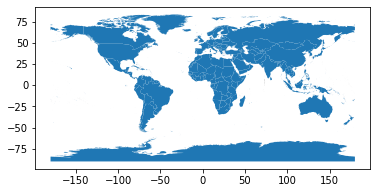

In [2]:
ne_10m = 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip'

r = requests.get(ne_10m)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/input/countries/")

world = gpd.read_file('data/input/countries/ne_10m_admin_0_countries.shp')

world.plot()

In [3]:
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,GEOU_DIF,GEOUNIT,GU_A3,SU_DIF,SUBUNIT,SU_A3,BRK_DIFF,NAME,NAME_LONG,BRK_A3,BRK_NAME,BRK_GROUP,ABBREV,POSTAL,FORMAL_EN,FORMAL_FR,NAME_CIAWF,NOTE_ADM0,NOTE_BRK,NAME_SORT,NAME_ALT,MAPCOLOR7,MAPCOLOR8,MAPCOLOR9,MAPCOLOR13,POP_EST,POP_RANK,POP_YEAR,GDP_MD,GDP_YEAR,ECONOMY,INCOME_GRP,FIPS_10,ISO_A2,ISO_A2_EH,ISO_A3,ISO_A3_EH,ISO_N3,ISO_N3_EH,UN_A3,WB_A2,WB_A3,WOE_ID,WOE_ID_EH,WOE_NOTE,ADM0_A3_IS,ADM0_A3_US,ADM0_A3_FR,ADM0_A3_RU,ADM0_A3_ES,ADM0_A3_CN,ADM0_A3_TW,ADM0_A3_IN,ADM0_A3_NP,ADM0_A3_PK,ADM0_A3_DE,ADM0_A3_GB,ADM0_A3_BR,ADM0_A3_IL,ADM0_A3_PS,ADM0_A3_SA,ADM0_A3_EG,ADM0_A3_MA,ADM0_A3_PT,ADM0_A3_AR,ADM0_A3_JP,ADM0_A3_KO,ADM0_A3_VN,ADM0_A3_TR,ADM0_A3_ID,ADM0_A3_PL,ADM0_A3_GR,ADM0_A3_IT,ADM0_A3_NL,ADM0_A3_SE,ADM0_A3_BD,ADM0_A3_UA,ADM0_A3_UN,ADM0_A3_WB,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_LEN,LONG_LEN,ABBREV_LEN,TINY,HOMEPART,MIN_ZOOM,MIN_LABEL,MAX_LABEL,NE_ID,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FA,NAME_FR,NAME_EL,NAME_HE,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT,FCLASS_ISO,FCLASS_US,FCLASS_FR,FCLASS_RU,FCLASS_ES,FCLASS_CN,FCLASS_TW,FCLASS_IN,FCLASS_NP,FCLASS_PK,FCLASS_DE,FCLASS_GB,FCLASS_BR,FCLASS_IL,FCLASS_PS,FCLASS_SA,FCLASS_EG,FCLASS_MA,FCLASS_PT,FCLASS_AR,FCLASS_JP,FCLASS_KO,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,0,Indonesia,IDN,0,Indonesia,IDN,0,Indonesia,Indonesia,IDN,Indonesia,None,Indo.,INDO,Republic of Indonesia,None,Indonesia,None,None,Indonesia,None,6,6,6,11,270625568.0,17,2019,1119190,2019,4. Emerging region: MIKT,4. Lower middle income,ID,ID,ID,IDN,IDN,360,360,360,ID,IDN,23424846,23424846,Exact WOE match as country,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,IDN,-99,-99,Asia,Asia,South-Eastern Asia,East Asia & Pacific,9,9,5,-99,1,0.0,1.7,6.7,1159320845,Q252,إندونيسيا,ইন্দোনেশিয়া,Indonesien,Indonesia,Indonesia,اندونزی,Indonésie,Ινδονησία,אינדונזיה,इंडोनेशिया,Indonézia,Indonesia,Indonesia,インドネシア,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Індонезія,انڈونیشیا,Indonesia,印度尼西亚,印度尼西亞,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,0,Malaysia,MYS,0,Malaysia,MYS,0,Malaysia,Malaysia,MYS,Malaysia,None,Malay.,MY,Malaysia,None,Malaysia,None,None,Malaysia,None,2,4,3,6,31949777.0,15,2019,364681,2019,6. Developing region,3. Upper middle income,MY,MY,MY,MYS,MYS,458,458,458,MY,MYS,23424901,23424901,Exact WOE match as country,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,MYS,-99,-99,Asia,Asia,South-Eastern Asia,East Asia & Pacific,8,8,6,-99,1,0.0,3.0,8.0,1159321083,Q833,ماليزيا,মালয়েশিয়া,Malaysia,Malaysia,Malasia,مالزی,Malaisie,Μαλαισία,מלזיה,मलेशिया,Malajzia,Malaysia,Malaysia,マレーシア,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Малайзія,ملائیشیا,Malaysia,马来西亚,馬來西亞,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,0,Chile,CHL,0,Chile,CHL,0,Chile,Chile,CHL,Chile,None,Chile,CL,Republic of Chile,None,Chile,None,None,Chile,None,5,1,5,9,18952038.0,14,2019,282318,2019,5. Emerging region: G20,3. Upper middle income,CI,CL,CL,CHL,CHL,152,152,152,CL,CHL,23424782,23424782,Exact WOE match as country,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL,CHL

### Load in the clean UCDP georeferenced data

In [4]:
df = pd.read_csv(gzip.open('data/manipulation/combined_and_tidied_geolocated_data.csv.gz', 'rb'))
df.tail()

,relid,year,geom_wkt,longitude,latitude,type_of_violence,best,low_amend,high_amend,conflict_new_id,country,country_id,region
280250,YEM-2022-2-14596-0,2022,POINT (45.41379 15.54686),45.413790,15.546860,2,4,4,5,13587,Yemen (North Yemen),678,Middle East
280251,YEM-2022-3-15781-1,2022,POINT (44.987222 12.889167),44.987222,12.889167,3,1,1,1,14511,Yemen (North Yemen),678,Middle East
280252,YEM-2022-2-15915-1,2022,POINT (47 15),47.000000,15.000000,2,2,2,2,14623,Yemen (North Yemen),678,Middle East
280253,YEM-2022-2-17014-0,2022,POINT (44.583332 13.166667),44.583332,13.166667,2,1,1,1,15505,Yemen (North Yemen),678,Middle East
280254,ZIM-2022-2-2-XXX552-0,2022,POINT (29.814863 -18.928095),29.814863,-18.928095,2,1,1,1,173,Zimbabwe (Rhodesia),552,Africa


## Map locations to countries

Convert UCDP data to a GeoDataFrame (so it can be mapped and used in spatial analysis)

In [5]:
df_geo = df[['relid','geom_wkt']]
df_geo.rename(columns={"geom_wkt":"geometry"}, inplace=True)
df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_geo, crs='epsg:4326')

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/854620756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)


Plot the UCDP data points on the world map to check it looks sensible

<AxesSubplot:>

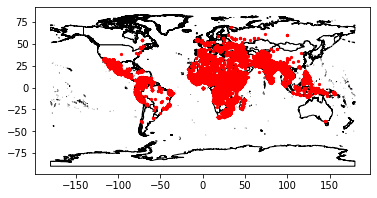

In [6]:
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)


Use the overlay function to extract data from the world map that each point sits on top of.

In [7]:
ucdp_ne = gpd.overlay(gdf, world, how='intersection')


In [8]:
ucdp_ne.shape[0] == df.shape[0]

False

There are 1688 points that are missed - likely because they are in the sea perhaps due to the conflict either happening at sea or at the coast and the coordinates are slightly inaccurate. 

In [9]:
df.shape[0] - ucdp_ne.shape[0]

1688

In [10]:
ucdp_orig = gdf.relid.to_list() 
ucdp_ex = ucdp_ne.relid.to_list()

main_list = list(set(ucdp_orig) - set(ucdp_ex))


In [11]:
missing_pts = gdf[gdf.relid.isin(main_list)]

For these points we can find the nearest country using the distance function

In [12]:
polygon_near = []
for index, row in missing_pts.iterrows():
    polygon_index = world.distance(row['geometry']).sort_values().index[0]
    country_name = world['NAME'][polygon_index]
    polygon_near.append(country_name)


/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/2149657748.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon_index = world.distance(row['geometry']).sort_values().index[0]


In [13]:
missing_pts['NAME'] = polygon_near

/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
missing_pts.head()

,relid,geometry,NAME
36971,ALG-1992-1-1-28,POINT (3.01148 36.81745),Algeria
36987,ALG-1992-1-1-44,POINT (2.92185 36.80277),Algeria
36988,ALG-1992-1-1-45,POINT (3.16667 36.75000),Algeria
37004,ALG-1992-1-1-61,POINT (3.91311 36.91716),Algeria
37149,ALG-1993-1-1-82,POINT (2.84389 36.76111),Algeria


In [15]:
df_intersect = df.merge(ucdp_ne[["relid", "NAME"]], on = "relid")
df_intersect.rename(columns = {"NAME":"country_name"}, inplace = True)
df_intersect['method'] = 'Intersect'

In [16]:
df_nearest = df.merge(missing_pts[["relid", "NAME"]], on = "relid")
df_nearest.rename(columns = {"NAME":"country_name"}, inplace = True)
df_nearest['method'] = 'Nearest'

We now have data for all the UCDP points

In [17]:
df_country= df_intersect.append(df_nearest).reset_index()


df_country.shape[0] == df.shape[0]


True

To align with OWID borders we will rename the 152 conflicts in Somaliland to Somalia and the five conflicts in Morocco that were below 27.66727 latitude to Western Sahara.

In [18]:
print(f"{len(df_country.loc[(df_country.country_name == 'Somaliland'),'country_name'])} datapoints in Somaliland")
df_country.loc[(df_country.country_name == 'Somaliland'),'country_name'] = 'Somalia'
print(f"{len(df_country.loc[(df_country.country_name == 'Morocco') & (df_country.latitude < 27.66727),'country_name'])} datapoints in land contested by Morocco/W.Sahara")
df_country.loc[(df_country.country_name == 'Morocco') & (df_country.latitude < 27.66727),'country_name'] = "Western Sahara"

155 datapoints in Somaliland
7 datapoints in land contested by Morocco/W.Sahara


I've added a flag column for points which I think are likely to have incorrect coordinates - points where latitude and longitude are exactly the same, or both 0.

In [19]:
df_country['flag'] = ""
df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
df_country['country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = "Could not be mapped"

/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/1557669971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/1557669971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = "Could not be mapped"


In [20]:
df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude = Longitude"
df_country['country_name'][df_country.latitude == df_country.longitude] = "Could not be mapped"

/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/388049751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude = Longitude"
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_37006/388049751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_name'][df_country.latitude == df_country.longitude] = "Could not be mapped"


## Output as zipped csv

In [21]:
df_country.rename(columns = {"country_name":"OWID_country_name"}, inplace = True)

In [22]:
df_country.to_csv('data/manipulation/ucdp_with_country.csv.gz', index = False, compression = "gzip")